In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn import preprocessing

In [2]:
data = pd.read_csv('./train_data/DATA.csv')
data = data[data.BMXWT != 0]

In [3]:
labels = (data['DXDTOLE']/data['BMXWT']) * 0.1
data['Label'] = labels
data = data.drop(['DXDTOLE'], axis=1)
data = data.fillna(0)

In [4]:
data['MCQ'] = (data.MCQ100==1) | (data.MCQ110==1)
data = data.drop(['MCQ100'], axis=1)
data = data.drop(['MCQ110'], axis=1)

In [5]:
data = data[['RIDAGEYR','RIAGENDR','BMXHT','BMXWT','DIQ010','MCQ160A','MCQ160I','MCQ','Label']]

In [6]:
# 分別從train裡面取train & test
import numpy as np
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [7]:
for item in data.columns.tolist():
    if data[item].corr(data.Label) > 0.2:
        print(item + ": " + "%.4f" % data[item].corr(data.Label))
    if data[item].corr(data.Label) < -0.2:
        print(item + ": " + "%.4f" % data[item].corr(data.Label))

RIAGENDR: -0.5679
BMXHT: 0.2214
BMXWT: -0.2279
MCQ160A: -0.2458
MCQ160I: -0.2525
Label: 1.0000


In [8]:
train.to_csv('./train_data/train_data.csv', index = False)
test.to_csv('./train_data/test_data.csv', index = False)

In [9]:
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


In [10]:
train_x = train.iloc[:,0:-1].values #returns a numpy array
train_y = train.iloc[:,-1].values.reshape(-1,1)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(train_x)
train_df = pd.DataFrame(x_scaled)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(train_y)
train_y = pd.DataFrame(x_scaled)

test_x = test.iloc[:,0:-1].values #returns a numpy array
test_y = test.iloc[:,-1].values.reshape(-1,1)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(test_x)
test_df = pd.DataFrame(x_scaled)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(test_y)
test_y = pd.DataFrame(x_scaled)

/Users/Emily/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [11]:
y_train = train_y.as_matrix()
x_train = train_df.iloc[:,:-1].as_matrix()
y_test = test_y.as_matrix()
x_test = test_df.iloc[:,:-1].as_matrix()

In [12]:
print(data.shape)

(6167, 9)


In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
model = Sequential()
model.add(Dense(units=4, input_dim=7))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=4, input_dim=4))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, input_dim=4))
model.add(Activation('relu'))
model.add(Dense(units=1, input_dim=2))

In [17]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save_weights('./model/doctor.model')
# save and load weights
model.save_weights('./model/my_doctor_weights.h5')
model.load_weights('./model/my_doctor_weights.h5')

Epoch 1/50
4922/4922 [==============================] - 0s - loss: 0.0295 - mean_absolute_error: 0.1057      

In [18]:
from sklearn.metrics import mean_squared_error
print(x_test.shape)
predict_y = model.predict(x_test)
# show the inputs and predicted outputs
# for i in range(len(x_test)):
# 	print("Item=%s, Predicted=%s, True=%s" % (i, predict_y[i], y_test[i]))
print(mean_squared_error(y_test, predict_y))

(1245, 7)
0.0260427966511


In [19]:
def denormalize(df, normalized_value): 
    df = df.values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

predict = denormalize(test.iloc[:,-1], predict_y)
true = denormalize(test.iloc[:,-1], y_test)

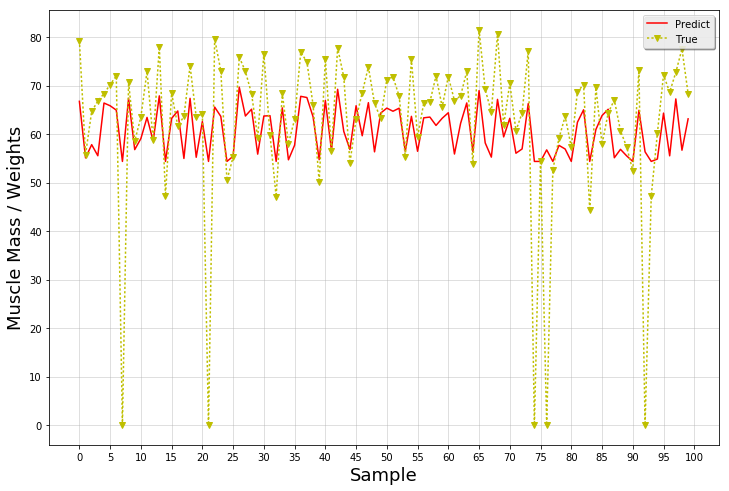

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

ts = []
for i in range(len(predict_y[:100])):
    ts.append(i)


# fig = plt.figure()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_xticks = np.arange(0, 101, 5)
minor_xticks = np.arange(0, 101, 0.1)

major_yticks = np.arange(0, 100, 10 )
minor_yticks = np.arange(0, 100, 0.1)

ax.set_xticks(major_xticks)
# ax.set_xticks(minor_xticks, minor=True)
ax.set_yticks(major_yticks)
# ax.set_yticks(minor_yticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.plot(ts, predict[:100],'r',ts, true[:100],'y:v') # 只有點
plt.xlabel('Sample',fontsize=18)
plt.ylabel('Muscle Mass / Weights',fontsize=18)

# plt.legend((p1[0], p2[0]), ('Men', 'Women'))
plt.legend(('Predict', 'True'),shadow=True,frameon=True)
plt.savefig('compare.png')
plt.show()

In [ ]:
print(test.shape)